#Assignment 19

### Here in this assignemnt we are going to preprocess face images and will create 4 clusters from all face object.

### To achieve this let's first download the data from google drive.

In [2]:
!pip install -U -q PyDrive
!git clone https://gist.github.com/dc7e60aa487430ea704a8cb3f2c5d6a6.git /tmp/colab_util_repo
!mv /tmp/colab_util_repo/colab_util.py colab_util.py 
!rm -r /tmp/colab_util_repo
from colab_util import *
drive_handler = GoogleDriveHandler()

Cloning into '/tmp/colab_util_repo'...
remote: Enumerating objects: 40, done.
remote: Total 40 (delta 0), reused 0 (delta 0), pack-reused 40
Unpacking objects: 100% (40/40), done.


In [0]:
drive_handler.download('RAW_Image.zip', target_path='EVA_Phase_1/Session 19/RAW_Image.zip')

### Let's Unzip the zip file and extract all images in the directory

In [0]:
# !rm -rf 'RAW Image'
# !rm RAW_Image.zip
import zipfile
from google.colab import drive

zip_ref = zipfile.ZipFile("RAW_Image.zip", 'r')
zip_ref.extractall("RAW_Image")
zip_ref.close()

### Now,let's rename the images as img1,img2,... etc.

In [0]:
def ReName_Multiple_Images(Imagepath,imgStartingName):
  import os
  # Function to rename multiple files 
  def main(): 
      i = 1

      for filename in os.listdir(Imagepath): 
          dst =imgStartingName + str(i) + ".jpg"
          src =Imagepath+ filename 
          dst =Imagepath+ dst 

          # rename() function will 
          # rename all the files 
          os.rename(src, dst) 
          i += 1

  # Driver Code 
  if __name__ == '__main__':       
      # Calling main() function 
      main() 

In [0]:
ReName_Multiple_Images('RAW_Image/RAW Image/','img')

### Now, Let's resize all images to 400 x 400

In [0]:
#import the library opencv
import cv2
#globbing utility.
import glob
from skimage import io
%matplotlib inline
from matplotlib import pyplot as plt

!mkdir 'RAW_Image_Resized'

#select the path
path = 'RAW_Image/RAW Image/*.*'
for bb,file in enumerate (glob.glob(path)):
    img = io.imread(file)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, dsize=(400, 400), interpolation=cv2.INTER_CUBIC)
    #writing the images in a folder output_images
    cv2.imwrite('RAW_Image_Resized/img{}.jpg'.format(bb+1), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    #wait for 1 second
    k = cv2.waitKey(1000)
    #destroy the window
    cv2.destroyAllWindows()

### Now let's zip those resized and upload in google drive to create annotation of objects

In [0]:
!zip -r RAW_Image_Resized.zip RAW_Image_Resized

In [11]:
drive_handler.upload('RAW_Image_Resized.zip', parent_path='EVA_Phase_1/Session 19/')

'1VWzttxMuKNFeHQwfis06blWGneizvoxf'

### Now let's download resized data again:

In [0]:
drive_handler.download('RAW_Image_Resized.zip', target_path='EVA_Phase_1/Session 19/RAW_Image_Resized.zip')

In [0]:
import zipfile
from google.colab import drive

zip_ref = zipfile.ZipFile("RAW_Image_Resized.zip", 'r')
zip_ref.extractall("RAW_Image_Resized")
zip_ref.close()

### Now let's download the annotation json file of all images

In [0]:
drive_handler.download('Annotation_File.zip', target_path='EVA_Phase_1/Session 19/Annotation_File.zip')

In [0]:
zip_ref = zipfile.ZipFile("Annotation_File.zip", 'r')
zip_ref.extractall("Annotation_File")
zip_ref.close()

In [0]:
import pandas as pd
import numpy as np

In [0]:
annotation_data = pd.read_json('Annotation_File/Annotation File/via_export_json.json')
annotation_data = annotation_data.transpose().reset_index()[['filename','regions']]

### We are going to create a dataframe containing all face object details

In [0]:
img_obj_list=pd.DataFrame(columns=['file_name', 'object_name', 'object_class', 'height', 'width', 'X', 'Y'])
for img in range(annotation_data.shape[0]):
  file_name = annotation_data['filename'][img]
  for img_obj in range(len(annotation_data['regions'][img])):
    obj_height = annotation_data['regions'][img][img_obj]['shape_attributes']['height']
    obj_width = annotation_data['regions'][img][img_obj]['shape_attributes']['width']
    obj_x = annotation_data['regions'][img][img_obj]['shape_attributes']['x']
    obj_y = annotation_data['regions'][img][img_obj]['shape_attributes']['y']
    obj_class = annotation_data['regions'][img][img_obj]['region_attributes']['Face']
    obj_name =  annotation_data['regions'][img][img_obj]['region_attributes']['Name']
    img_obj_list = img_obj_list.append({'file_name': file_name,'object_name': obj_name, 'object_class': obj_class, 'height': obj_height,'width': obj_width, 'X': obj_x, 'Y': obj_y}, ignore_index=True)
  


In [64]:
img_obj_list.head()

,file_name,object_name,object_class,height,width,X,Y
0,img1.jpg,face1,DownRight,57,33,132,120
1,img1.jpg,face2,DownLeft,63,43,230,51
2,img1.jpg,face3,Right,47,37,174,169
3,img2.jpg,face1,Back,161,84,53,27
4,img2.jpg,face2,Front,68,35,300,274


### Now, let's download the file and save it in our local

In [0]:
img_obj_list.to_csv('img_obj_list.csv', index=False)
from google.colab import files
files.download('img_obj_list.csv') 

### As our data preprossing is done. Now we are going to perform k-means clustering on top of this data to extract top 4 cluster details:

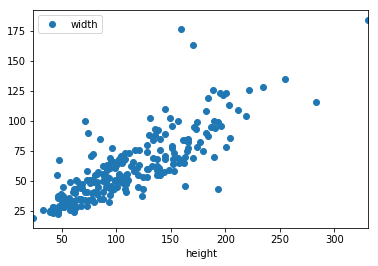

In [69]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
#JointPlots

img_obj_list.plot(x='height', y='width', style='o')

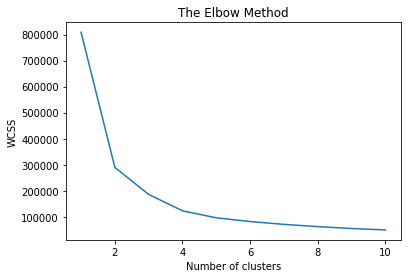

In [90]:
# Using the elbow method to find the optimal number of clusters
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(img_obj_list[['width','height']])
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(img_obj_list[['width','height']])

In [93]:
X = img_obj_list[['height','width']]
X['y_kmeans'] = kmeans.fit_predict(X)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


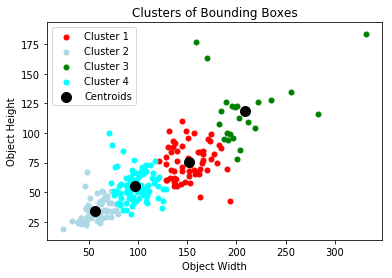

In [103]:
# Visualising the clusters
plt.scatter(X[y_kmeans == 0]['height'],X[y_kmeans == 0]['width'], s = 25, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1]['height'], X[y_kmeans == 1]['width'], s = 25, c = 'lightblue', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2]['height'], X[y_kmeans == 2]['width'], s = 25, c = 'green', label = 'Cluster 3')
plt.scatter(X[y_kmeans == 3]['height'], X[y_kmeans == 3]['width'], s = 25, c = 'cyan', label = 'Cluster 4')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'black', label = 'Centroids')
plt.title('Clusters of Bounding Boxes')
plt.xlabel('Object Width')
plt.ylabel('Object Height')
plt.legend()
plt.show()

In [99]:
#### 4 clusters centroid value
centroid_height = kmeans.cluster_centers_[:, 0]
centroid_width = kmeans.cluster_centers_[:, 1]
for i in range(4):
  print("(" + str(centroid_height[i]) + " , " + str(centroid_width[i]) + ")")

(151.8166666666667 , 75.45)
(56.47142857142853 , 34.07142857142853)
(208.69565217391303 , 118.43478260869563)
(97.25287356321839 , 55.298850574712645)


### So, from the above we can conclude 4 cluster dimensions are: (151.8166666666667 , 75.45),       (56.47142857142853 , 34.07142857142853), (208.69565217391303 , 118.43478260869563), (97.25287356321839 , 55.298850574712645)